In [10]:
import cobra
from cobra.sampling import sample
from cobra.sampling import OptGPSampler
from cobra.flux_analysis import flux_variability_analysis
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.patches import Patch
#from matplotlib import colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu
import seaborn as sns
import os
import pickle
import lzma

In [2]:
def multisample(model, n, runs=5, threads=1):
    n_per_run = int(n/runs)
    if n_per_run*runs != n:
        print("Note: specified number of samples is not divisible by number of runs")
    print("Collecting {r} samples of size {x}, for {y} total samples".format(r=runs, x=n_per_run, y=runs*n_per_run))
    #p = Pool(nodes=threads)
    #result = p.uimap(partial(sample, processes=1), (model,)*runs, (n_per_run,)*runs)
    #p.close()
    #p.join()
    #p.clear()
    result = []
    for i in range(runs):
        s = sample(model, n_per_run, processes=threads)
        result.append(s)
    return pd.concat(result, axis=0).reset_index()
def create_rxn(model, name, cpd_dict, direction="both", limits=None):
    # Create a reaction from a dict with {"CPD1": -1, "CPD2: 1"}
    # Assuming the cpd ids are already in the model
    if direction not in ["forward", "reverse", "both"]:
        raise ValueError("Direction must be either forward, reverse, or both")
    rxn = cobra.Reaction(name)
    if limits is not None:
        if len(limits) != 2:
            raise ValueError("Limits must be of length 2")
        else:
            rxn.lower_bound = limits[0]
            rxn.upper_bound = limits[1]
    elif direction == "both":
        rxn.lower_bound = -1000
        rxn.upper_bound = 1000
    elif direction == "forward":
        rxn.lower_bound = 0
        rxn.upper_bound = 1000
    else:
        rxn.lower_bound = -1000
        rxn.upper_bound = 0
    rxn.add_metabolites({
        getattr(model.metabolites, cpd): val for cpd, val in cpd_dict.items()
    })
    print("Adding the following reaction to model:")
    print(rxn)
    model.add_reactions([rxn])
def mannwhitney_test_columns(df1, df2, decimals=4):
    """
    Compares all columns that are shared between two dataframes
    outputs p value from mannwhitney U test and the effect size as cohen's d: (u2 - u1)/stdev
    """
    rxn_list = set(df1.columns.values).intersection(set(df2.columns.values))
    sig_test_out = {}
    statistic_out = {}
    median1 = {}
    median2 = {}
    effect_size = 0
    dfs_rounded = [df.round(decimals) for df in [df1, df2]]
    for rxn in rxn_list:
        arrays = [df[rxn] for df in dfs_rounded]
        median1[rxn] = arrays[0].median()
        median2[rxn] = arrays[1].median()
        if np.concatenate(arrays).var().round(decimals) == 0:
            sig_test_out[rxn] = 1
            statistic_out[rxn] = 0
        else:
            test = mannwhitneyu(*arrays)
            sig_test_out[rxn] = test.pvalue
            #statistic_out[rxn] = norm.isf(test.pvalue/2)/sqrt(len(arrays[0]))
            statistic_out[rxn] = (arrays[1].mean() - arrays[0].mean())/arrays[0].std()
    df = pd.concat([pd.Series(sig_test_out), pd.Series(statistic_out), pd.Series(median1), pd.Series(median2)], axis=1)
    df.columns = ["pvalue", "effect_size", "median1", "median2"]
    return df

In [3]:
cobra_config = cobra.Configuration()
cobra_config.solver = "cplex"

In [4]:
with open("../sbmls/b971180d_YM_closed.sbml") as f:
    YM_closed = cobra.io.read_sbml_model(f)
with open("../sbmls/b971180d_YM_open.sbml") as f:
    YM_open = cobra.io.read_sbml_model(f)

'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.


## Universal constraints
1. GAPDH is removed in glycolytic conditions
2. GAPOR is removed in gluconeogenic conditions
3. OE-Adhf limits on ethanol production (See Fig3 notebook)

In [5]:
for model in [YM_closed, YM_open]:
    model.reactions.R01061.upper_bound = 0
    model.reactions.R01063.upper_bound = 0

In [6]:
## Constraints for OE-AdhF
YM_closed.reactions.TP_ETOH.lower_bound = 3.29265
YM_open.reactions.TP_ETOH.lower_bound = 0.6934

In [7]:
with lzma.open("pickles/s3.pkl.xz", "rb") as f:
    s, s_atp_conversion, s_fedRd_conversion, s_nadph_conversion, s_noH2, s_noH2_atp_conversion, s_noH2_fedRd, s_noH2_nadph_conversion = pickle.load(f)

## Figure 5

In [8]:
atp_conversion = {"C00008": -1, "C00009": -1, "C00001": 1, "C00002": 1}
fed_conversion = {"C00139": -1, "C00138": 1, "C00080": 1}
nadph_conversion = {"C00006": -1, "C00080": 1, "C00005": 1}

**Skip if you loaded the samples above**

In [18]:
s = multisample(YM_closed, 2500, runs=10, threads=5)

create_rxn(YM_closed, "atp_conversion", atp_conversion, direction="forward")
s_atp_conversion = multisample(YM_closed, 2500, runs=10, threads=5)
YM_closed.remove_reactions(["atp_conversion"])

create_rxn(YM_closed, "fedRd_conversion", fed_conversion, direction="forward")
s_fedRd_conversion = multisample(YM_closed, 2500, runs=10, threads=5)
YM_closed.remove_reactions(["fedRd_conversion"])

create_rxn(YM_closed, "nadph_conversion", nadph_conversion, direction="forward")
s_nadph_conversion = multisample(YM_closed, 2500, runs=10, threads=5)
YM_closed.remove_reactions(["nadph_conversion"])

Adding the following reaction to model:
atp_conversion: C00008 + C00009 --> C00001 + C00002
Adding the following reaction to model:
fedRd_conversion: C00139 --> C00080 + C00138
Adding the following reaction to model:
nadph_conversion: C00006 --> C00005 + C00080


**Skip if you loaded the samples above**

In [19]:
s_noH2 = multisample(YM_open, 2500, runs=10, threads=5)

create_rxn(YM_open, "atp_conversion", atp_conversion, direction="forward")
s_noH2_atp_conversion = multisample(YM_open, 2500, runs=10, threads=5)
YM_open.remove_reactions(["atp_conversion"])

create_rxn(YM_open, "fed_conversion", fed_conversion, direction="forward")
s_noH2_fedRd = multisample(YM_open, 2500, runs=10, threads=5)
YM_open.remove_reactions(["fed_conversion"])

create_rxn(YM_open, "nadph_conversion", nadph_conversion, direction="forward")
s_noH2_nadph_conversion = multisample(YM_open, 2500, runs=10, threads=5)
YM_open.remove_reactions(["nadph_conversion"])

Adding the following reaction to model:
atp_conversion: C00008 + C00009 --> C00001 + C00002
Adding the following reaction to model:
fed_conversion: C00139 --> C00080 + C00138
Adding the following reaction to model:
nadph_conversion: C00006 --> C00005 + C00080


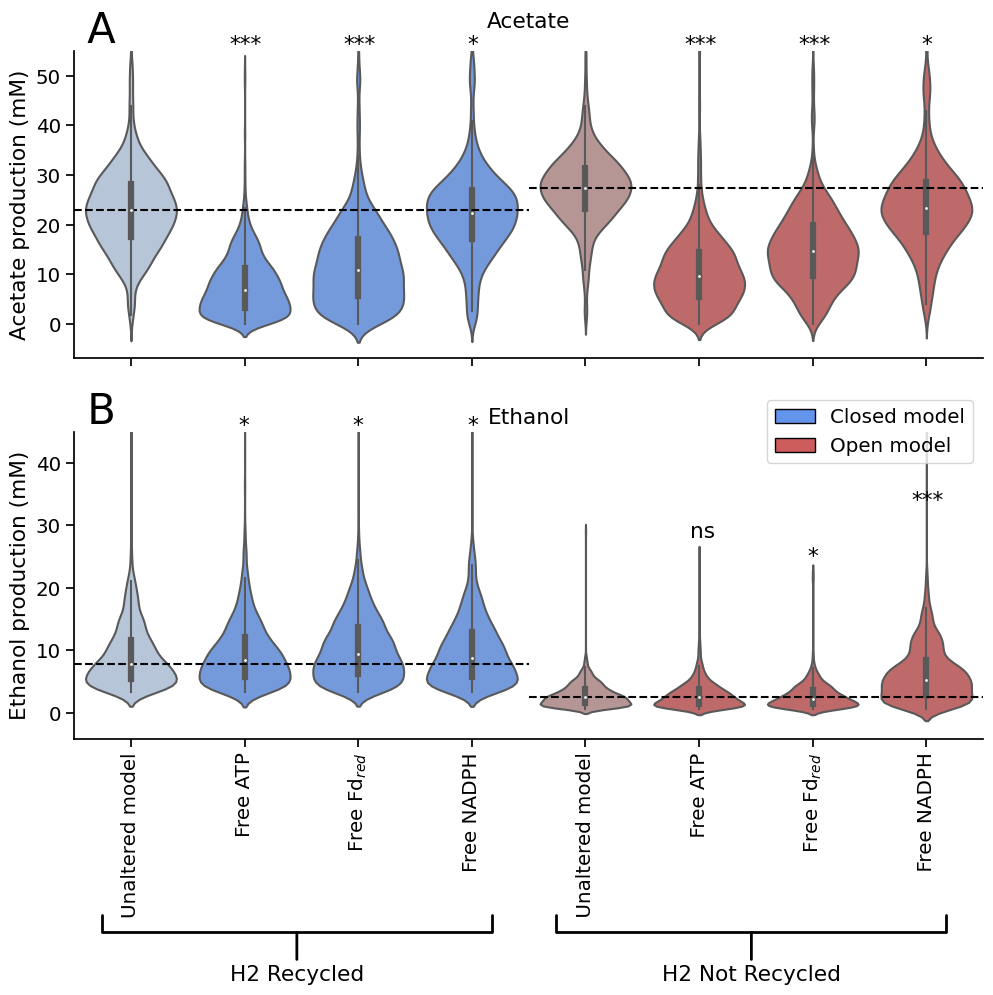

In [11]:
df1 = pd.DataFrame({"Unaltered model": s.TP_ace, "Free ATP": s_atp_conversion.TP_ace,
                   "Free Fd$_{red}$": s_fedRd_conversion.TP_ace,
                   "Free NADPH": s_nadph_conversion.TP_ace,
                   " Unaltered model": s_noH2.TP_ace,
                   " Free ATP": s_noH2_atp_conversion.TP_ace,
                   " Free Fd$_{red}$": s_noH2_fedRd.TP_ace,
                   " Free NADPH": s_noH2_nadph_conversion.TP_ace})
df2 = pd.DataFrame({"Unaltered model": s.TP_ETOH, "Free ATP": s_atp_conversion.TP_ETOH,
                   "Free Fd$_{red}$": s_fedRd_conversion.TP_ETOH,
                   "Free NADPH": s_nadph_conversion.TP_ETOH,
                   " Unaltered model": s_noH2.TP_ETOH,
                   " Free ATP": s_noH2_atp_conversion.TP_ETOH,
                   " Free Fd$_{red}$": s_noH2_fedRd.TP_ETOH,
                   " Free NADPH": s_noH2_nadph_conversion.TP_ETOH})
df1["Product"] = "Acetate"
df2["Product"] = "Ethanol"
df = pd.concat([df1, df2]).reset_index().drop(columns=["index"])
with sns.plotting_context("notebook", font_scale=1.3):
    plt.rcParams["figure.figsize"] = (9, 11)
    g = sns.FacetGrid(df, col="Product", col_wrap=1,
                      aspect=1.7, height=6, sharey=False)
    g.map_dataframe(sns.violinplot, palette=(["lightsteelblue"]+3*["cornflowerblue"]+["rosybrown"]+3*["indianred"]),
                    scale="count", )
    # Titles/axis labels
    g.axes[0].set_ylabel("Acetate production (mM)")
    g.axes[0].set_title("Acetate", loc="center", y=1.05,)
    g.axes[0].set_title(" A", loc="left", fontdict={"fontsize": 30, "fontweight": 500})
    g.axes[0].axhline(df1["Unaltered model"].median(), xmax=0.5, ls="dashed", color="black")
    g.axes[0].axhline(df1[" Unaltered model"].median(), xmin=0.5, ls="dashed", color="black")
    g.axes[1].set_ylabel("Ethanol production (mM)")
    g.axes[1].set_title("Ethanol", loc="center", y=1)
    g.axes[1].set_title(" B", loc="left", fontdict={"fontsize": 30, "fontweight": 500})
    g.axes[1].axhline(df2["Unaltered model"].median(), xmax=0.5, ls="dashed", color="black")
    g.axes[1].axhline(df2[" Unaltered model"].median(), xmin=0.5, ls="dashed", color="black")
    g.axes[0].set_ylim(g.axes[0].get_ylim()[0], 55)
    g.axes[1].set_ylim(g.axes[1].get_ylim()[0], 45)
    plt.xticks(rotation=90)
    # Adding legend
    legend_elements = [Patch(facecolor="cornflowerblue", edgecolor="black",
                             label="Closed model"),
                       Patch(facecolor="indianred", edgecolor="black",
                             label="Open model")]
    plt.legend(handles=legend_elements, loc="center right", bbox_to_anchor=(1, 1))
    # Adding brackets on bottom
    g.axes[1].annotate("H2 Recycled", xy=(0.245, -0.62), xytext=(0.245, -0.80),
                       fontsize=1.3*12, ha="center", va="bottom", xycoords="axes fraction", 
                       arrowprops=dict(arrowstyle="-[, widthB=9.0, lengthB=.8", lw=2.0))
    g.axes[1].annotate("H2 Not Recycled", xy=(0.745, -0.62), xytext=(0.745, -0.80),
                       fontsize=1.3*12, ha="center", va="bottom", xycoords="axes fraction", 
                       arrowprops=dict(arrowstyle="-[, widthB=9.0, lengthB=.8", lw=2.0))
    # Adding significance asterisks
    # Top row
    g.axes[0].annotate("***", xy=(0.87,55))
    g.axes[0].annotate("***", xy=(1.87,55))
    g.axes[0].annotate("*",   xy=(2.96,55))
    g.axes[0].annotate("***", xy=(4.87,55))
    g.axes[0].annotate("***", xy=(5.87,55))
    g.axes[0].annotate("*",   xy=(6.96,55))
    # Bottom row
    g.axes[1].annotate("*",  xy=(0.95,45))
    g.axes[1].annotate("*",   xy=(1.95,45))
    g.axes[1].annotate("*",   xy=(2.96,45))
    g.axes[1].annotate("ns",   xy=(4.92,28))
    g.axes[1].annotate("*",  xy=(5.95,24))
    g.axes[1].annotate("***", xy=(6.87,33))
    plt.tight_layout()
    plt.savefig("figures/Fig5.tiff",
                dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

In [12]:
with lzma.open("./pickles/s3.pkl.xz", "wb") as f:
    pickle.dump([s, s_atp_conversion, s_fedRd_conversion, s_nadph_conversion, s_noH2, s_noH2_atp_conversion, s_noH2_fedRd, s_noH2_nadph_conversion], f)

## Table S3

In [12]:
combined = [pd.DataFrame(s[["TP_ETOH", "TP_ace"]].median()).T.rename(index={0: "median"})]
for sam in [s_atp_conversion, s_fedRd_conversion, s_nadph_conversion, ]:
    combined.append(mannwhitney_test_columns(s[["TP_ace", "TP_ETOH"]], sam[["TP_ace", "TP_ETOH"]]).T.drop(index="median1").rename(
        index={"median2": "median"}).loc[["median", "pvalue", "effect_size"]])
dfclosed = pd.concat(combined).rename(index={"median": "median (mM)", "effect_size": "effect size (d)"},
                                  columns={"TP_ETOH": "Ethanol", "TP_ace": "Acetate"}).round(10)

In [13]:
combined_noH2 = [pd.DataFrame(s_noH2[["TP_ETOH", "TP_ace"]].median()).T.rename(index={0: "median"})]
for sam in [s_noH2_atp_conversion, s_noH2_fedRd, s_noH2_nadph_conversion]:
    combined_noH2.append(mannwhitney_test_columns(s_noH2[["TP_ace", "TP_ETOH"]], sam[["TP_ace", "TP_ETOH"]]).T.drop(index="median1").rename(
        index={"median2": "median"}).loc[["median", "pvalue", "effect_size"]])
dfopen = pd.concat(combined_noH2).rename(index={"median": "median (mM)", "effect_size": "effect size (d)"},
                                           columns={"TP_ETOH": "Ethanol", "TP_ace": "Acetate"}).round(10)

In [14]:
df = pd.concat([dfclosed, dfopen], axis=1)
df["Model"] = ["Unaltered model", "Free ATP", "Free ATP", "Free ATP",
               "Free FdRed", "Free FdRed", "Free FdRed", 
               "Free NADPH", "Free NADPH", "Free NADPH",]
df.set_index("Model", append=True, inplace=True)
df = df.reorder_levels(["Model", None])
df.columns = pd.MultiIndex.from_tuples(list(zip(["Closed", "Closed", "Open", "Open"], df.columns)))

In [15]:
df.round(3)

Closed            Open        
                                Ethanol Acetate Ethanol Acetate
Model                                                          
Unaltered model median (mM)       7.806  22.888   2.502  27.469
Free ATP        median (mM)       8.496   6.840   2.481   9.637
                pvalue            0.000   0.000   0.462   0.000
                effect size (d)   0.083  -1.833   0.066  -2.288
Free FdRed      median (mM)       9.449  10.853   2.289  14.642
                pvalue            0.000   0.000   0.000   0.000
                effect size (d)   0.222  -1.315  -0.032  -1.657
Free NADPH      median (mM)       8.820  22.283   5.315  23.387
                pvalue            0.000   0.001   0.000   0.000
                effect size (d)   0.141  -0.099   1.749  -0.484

In [16]:
df.round(3).to_csv("./figures/TableS3.csv")